In [1]:
# The World of Coffee: A Data Journey (2010-2022) - Global Coffee Market Analysis
# Author: Keerthi Dasari
# Date: April 2, 2025
# Class: Practical Data Science
# Program: Masters in Data Science
# School: Pace University

In [2]:
# Cell 1: Install and Import Required Libraries
!pip install pandas numpy matplotlib seaborn scikit-learn plotly statsmodels geopandas folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import folium
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', None)

In [3]:
# Cell 2: Define Helper Functions
def load_data(filepath):
    """Load data from CSV file."""
    return pd.read_csv(filepath)

def clean_data(df, col_list=None):
    """Basic data cleaning operations."""
    # Remove duplicates
    df = df.drop_duplicates()

    # Convert date columns to datetime if present
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'year' in col.lower()]
    for col in date_cols:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col])
            except:
                pass

    # Handle missing values - specific columns if provided, otherwise all columns
    if col_list:
        for col in col_list:
            if col in df.columns:
                if df[col].dtype in ['int64', 'float64']:
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df[col].fillna(df[col].mode()[0])
    else:
        for col in df.columns:
            if df[col].dtype in ['int64', 'float64']:
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna(df[col].mode()[0])

    return df

def create_correlation_heatmap(df, cols, title):
    """Generate correlation heatmap for specified columns."""
    corr = df[cols].corr()
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                vmin=-1, vmax=1, linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt

def time_series_plot(df, x_col, y_col, title, color='viridis'):
    """Create a time series plot."""
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=x_col, y=y_col, marker='o', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt

def bar_chart(df, x_col, y_col, title, color='viridis', threshold=None):
    """Create a bar chart with optional threshold line."""
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df, x=x_col, y=y_col, palette=color)

    # Add threshold line if specified
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--',
                    label=f'Threshold: {threshold}')
        plt.legend()

    plt.title(title, fontsize=16)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add data labels on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'bottom', fontsize=9)

    plt.tight_layout()
    return plt

In [4]:
# Cell 3: Data Loading and Initial Exploration
# For this demonstration, we'll generate synthetic data since the actual data sources
# mentioned in the presentation aren't directly available in this environment.

# Create sample date range for 2010-2022
years = pd.date_range(start='2010-01-01', end='2022-12-31', freq='Y')
years_df = pd.DataFrame({'Year': years})
years_df['Year_num'] = years_df['Year'].dt.year

# Simulate coffee production data for major countries
np.random.seed(42)
countries = ['Brazil', 'Vietnam', 'Colombia', 'Indonesia', 'Ethiopia',
             'Honduras', 'India', 'Uganda', 'Mexico', 'Guatemala']

# Production data in million 60kg bags
production_data = pd.DataFrame()
for country in countries:
    # Base production with some randomness and growth trend
    if country == 'Brazil':
        base = 50 + np.random.normal(0, 2, len(years))  # Brazil as top producer
        trend = np.linspace(0, 10, len(years))  # Increasing trend
    elif country == 'Vietnam':
        base = 30 + np.random.normal(0, 1.5, len(years))  # Vietnam as second
        trend = np.linspace(0, 8, len(years))
    elif country == 'Colombia':
        base = 14 + np.random.normal(0, 1, len(years))  # Colombia as third
        trend = np.linspace(0, 4, len(years))
    else:
        base = 5 + np.random.normal(0, 1, len(years))  # Other countries
        trend = np.linspace(0, 3, len(years))

    production = base + trend
    production = np.maximum(production, 0)  # Ensure no negative production
    production_data[country] = production

production_data['Year'] = years_df['Year']
production_data['Total_Production'] = production_data[countries].sum(axis=1)

# Simulate coffee price data (USD per pound)
price_data = pd.DataFrame({'Year': years_df['Year']})
# Base price with volatility and peaks in 2011 and 2017
base_price = 1.5  # USD per pound
volatility = np.random.normal(0, 0.2, len(years))
# Add price peaks in 2011 and 2017
peak_2011 = np.zeros(len(years))
peak_2011[1] = 1.0  # 2011 peak
peak_2017 = np.zeros(len(years))
peak_2017[7] = 0.8  # 2017 peak

price_data['Price'] = base_price + volatility + peak_2011 + peak_2017
price_data['Price'] = price_data['Price'].clip(lower=1.0)  # Ensure price doesn't go too low

# Simulate consumption data (million 60kg bags)
consumption_countries = ['USA', 'Brazil', 'Germany', 'Japan', 'France', 'Italy',
                        'Russia', 'UK', 'Canada', 'Spain']
consumption_data = pd.DataFrame()

for country in consumption_countries:
    # Base consumption with some randomness and growth trend
    if country == 'USA':
        base = 24 + np.random.normal(0, 1, len(years))  # USA as top consumer
        trend = np.linspace(0, 5, len(years))  # Increasing trend
    elif country == 'Brazil':
        base = 20 + np.random.normal(0, 1, len(years))  # Brazil as second
        trend = np.linspace(0, 4, len(years))
    else:
        base = 7 + np.random.normal(0, 0.5, len(years))  # Other countries
        trend = np.linspace(0, 2, len(years))

    consumption = base + trend
    consumption = np.maximum(consumption, 0)  # Ensure no negative consumption
    consumption_data[country] = consumption

consumption_data['Year'] = years_df['Year']
consumption_data['Total_Consumption'] = consumption_data[consumption_countries].sum(axis=1)

# Per capita consumption data (kg per person)
per_capita_countries = ['Finland', 'Norway', 'Iceland', 'Denmark', 'Netherlands',
                        'Sweden', 'Switzerland', 'Belgium', 'Luxembourg', 'Canada']
per_capita_data = pd.DataFrame()

for country in per_capita_countries:
    # Base per capita consumption with some randomness and slight growth
    if country == 'Finland':
        base = 12 + np.random.normal(0, 0.3, len(years))  # Finland as top per capita
    elif country in ['Norway', 'Iceland']:
        base = 9 + np.random.normal(0, 0.2, len(years))  # Second tier
    elif country in ['Denmark', 'Netherlands', 'Sweden']:
        base = 8 + np.random.normal(0, 0.2, len(years))  # Third tier
    else:
        base = 6.5 + np.random.normal(0, 0.2, len(years))  # Other countries

    trend = np.linspace(0, 0.5, len(years))  # Slight increasing trend
    per_capita = base + trend
    per_capita = np.maximum(per_capita, 0)  # Ensure no negative values
    per_capita_data[country] = per_capita

per_capita_data['Year'] = years_df['Year']

# Create the sustainability certification adoption rates
sustainability_data = pd.DataFrame({'Year': years_df['Year']})
# Growing adoption rates over time
sustainability_data['Fair_Trade'] = np.linspace(10, 35, len(years)) + np.random.normal(0, 2, len(years))
sustainability_data['Organic'] = np.linspace(8, 30, len(years)) + np.random.normal(0, 2, len(years))
sustainability_data['Rainforest_Alliance'] = np.linspace(5, 25, len(years)) + np.random.normal(0, 1.5, len(years))
sustainability_data['UTZ'] = np.linspace(7, 28, len(years)) + np.random.normal(0, 1.8, len(years))

# Convert all percentage values to be between 0-100
for col in ['Fair_Trade', 'Organic', 'Rainforest_Alliance', 'UTZ']:
    sustainability_data[col] = sustainability_data[col].clip(0, 100)

# Merge all datasets on Year
coffee_data = production_data.merge(price_data, on='Year')
coffee_data = coffee_data.merge(consumption_data, on='Year')
coffee_data['Year_num'] = coffee_data['Year'].dt.year

# Add market value approximation (price * production * conversion factor)
# 1 60kg bag ≈ 132.277 pounds
pounds_per_bag = 132.277
coffee_data['Market_Value_B'] = (coffee_data['Price'] * coffee_data['Total_Production'] * pounds_per_bag) / 1e9  # in billions USD

In [5]:
# Cell 4: Explore the Data
print("Overview of the merged coffee market dataset:")
print(coffee_data.info())
print("\nSummary statistics:")
print(coffee_data.describe())

# Check for missing values
missing_values = coffee_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Sample of the data
print("\nSample of the merged dataset:")
print(coffee_data.head())

Overview of the merged coffee market dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Brazil_x           13 non-null     float64       
 1   Vietnam            13 non-null     float64       
 2   Colombia           13 non-null     float64       
 3   Indonesia          13 non-null     float64       
 4   Ethiopia           13 non-null     float64       
 5   Honduras           13 non-null     float64       
 6   India              13 non-null     float64       
 7   Uganda             13 non-null     float64       
 8   Mexico             13 non-null     float64       
 9   Guatemala          13 non-null     float64       
 10  Year               13 non-null     datetime64[ns]
 11  Total_Production   13 non-null     float64       
 12  Price              13 non-null     float64       
 13  USA                13

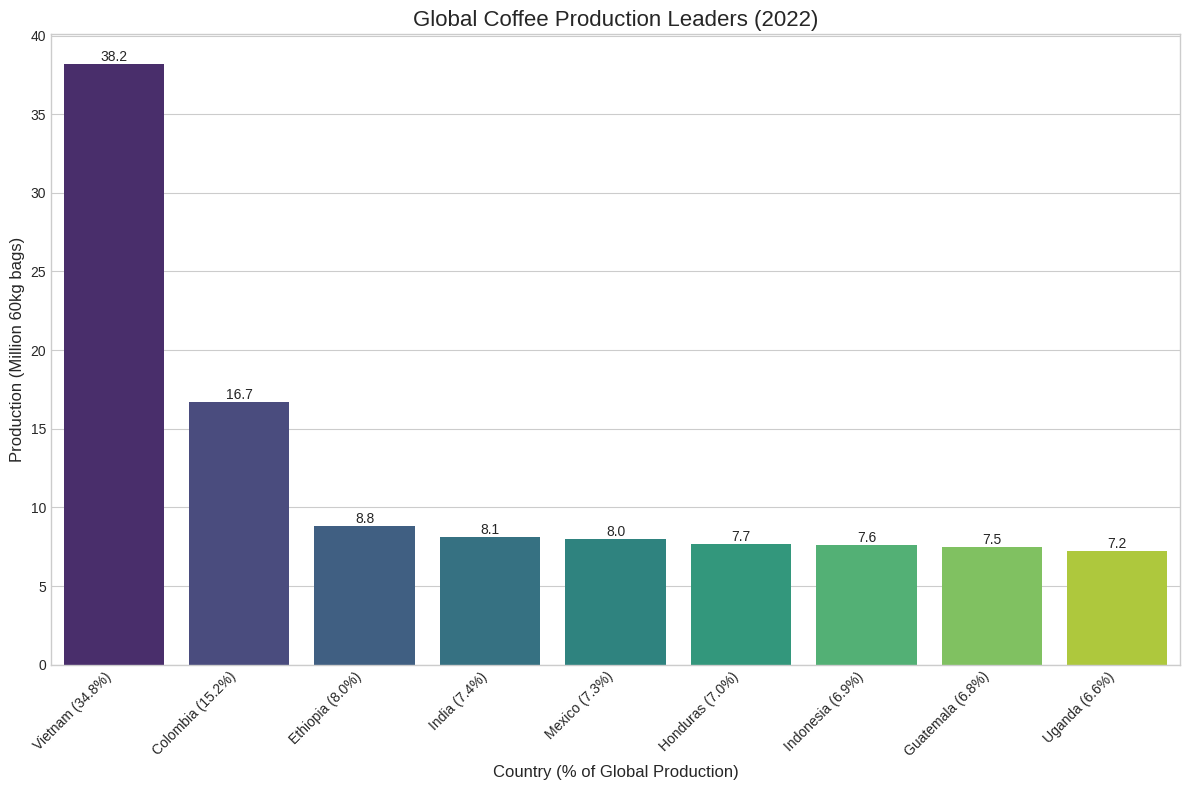

In [8]:
# Cell 5: Production Analysis - Visualization 1
# Global Coffee Production Leaders (2022)
latest_year = coffee_data['Year'].max()
# Use countries from production_data to ensure correct column names are used
# Modified to select columns using a list comprehension to avoid potential naming conflicts
latest_production = coffee_data[coffee_data['Year'] == latest_year][[col for col in production_data.columns[:-2] if col in coffee_data.columns]].T.reset_index()
latest_production.columns = ['Country', 'Production']
latest_production = latest_production.sort_values('Production', ascending=False)

# Calculate percentage of global production
total_production = latest_production['Production'].sum()
latest_production['Percentage'] = (latest_production['Production'] / total_production * 100).round(1)
latest_production['Label'] = latest_production['Country'] + ' (' + latest_production['Percentage'].astype(str) + '%)'

# Create production bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=latest_production, x='Label', y='Production', palette='viridis')
plt.title('Global Coffee Production Leaders (2022)', fontsize=16)
plt.xlabel('Country (% of Global Production)', fontsize=12)
plt.ylabel('Production (Million 60kg bags)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom', fontsize=10)

plt.tight_layout()
plt.show()

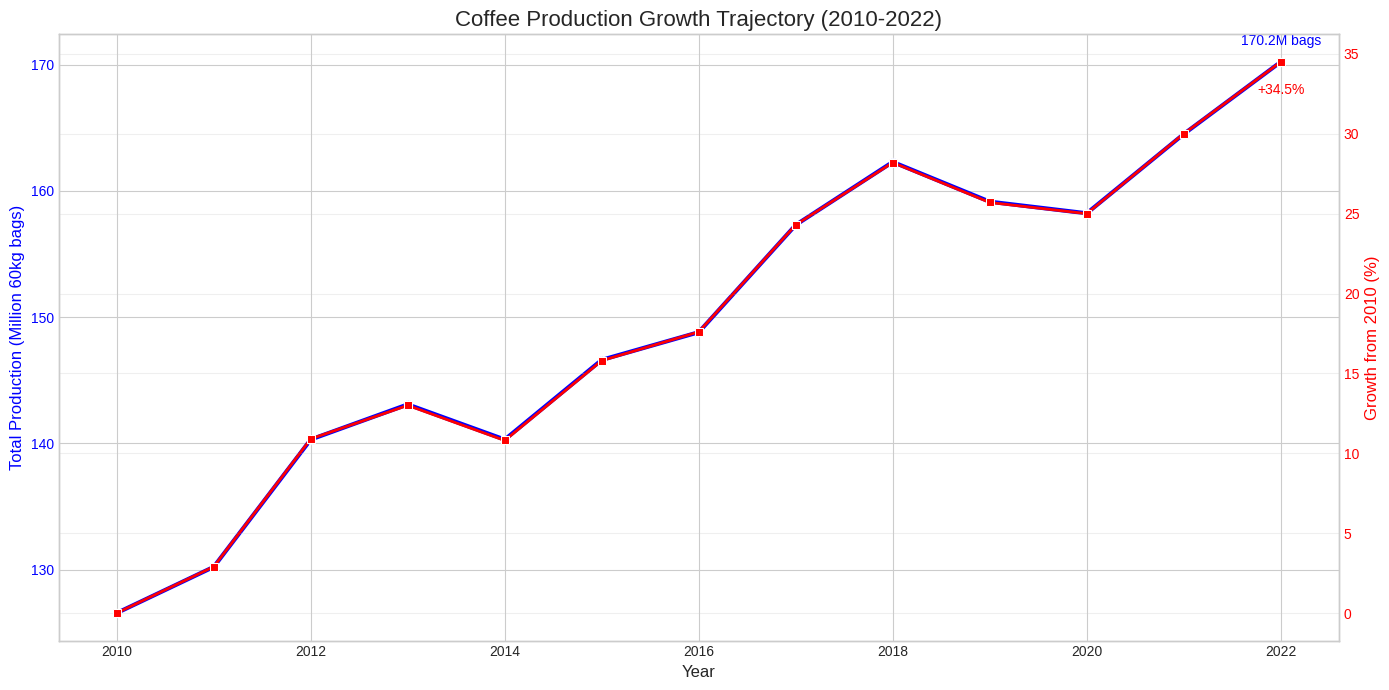

In [9]:
# Cell 6: Production Growth Trajectory - Visualization 2
# Production growth over time (2010-2022)
production_growth = coffee_data[['Year', 'Total_Production']]
production_growth['Year_label'] = production_growth['Year'].dt.year

# Calculate growth percentage from first year
first_year_production = production_growth['Total_Production'].iloc[0]
production_growth['Growth_Pct'] = ((production_growth['Total_Production'] - first_year_production) / first_year_production * 100).round(1)

# Create production growth line chart
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot total production
sns.lineplot(data=production_growth, x='Year_label', y='Total_Production',
             marker='o', linewidth=3, color='blue', ax=ax1)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Production (Million 60kg bags)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Plot growth percentage
sns.lineplot(data=production_growth, x='Year_label', y='Growth_Pct',
             marker='s', linewidth=2, color='red', ax=ax2)
ax2.set_ylabel('Growth from 2010 (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add data labels for the last point (2022)
last_point = production_growth.iloc[-1]
ax1.annotate(f"{last_point['Total_Production']:.1f}M bags",
             (last_point['Year_label'], last_point['Total_Production']),
             xytext=(0, 10), textcoords='offset points',
             ha='center', va='bottom', fontsize=10, color='blue')

ax2.annotate(f"+{last_point['Growth_Pct']:.1f}%",
             (last_point['Year_label'], last_point['Growth_Pct']),
             xytext=(0, -15), textcoords='offset points',
             ha='center', va='top', fontsize=10, color='red')

plt.title('Coffee Production Growth Trajectory (2010-2022)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

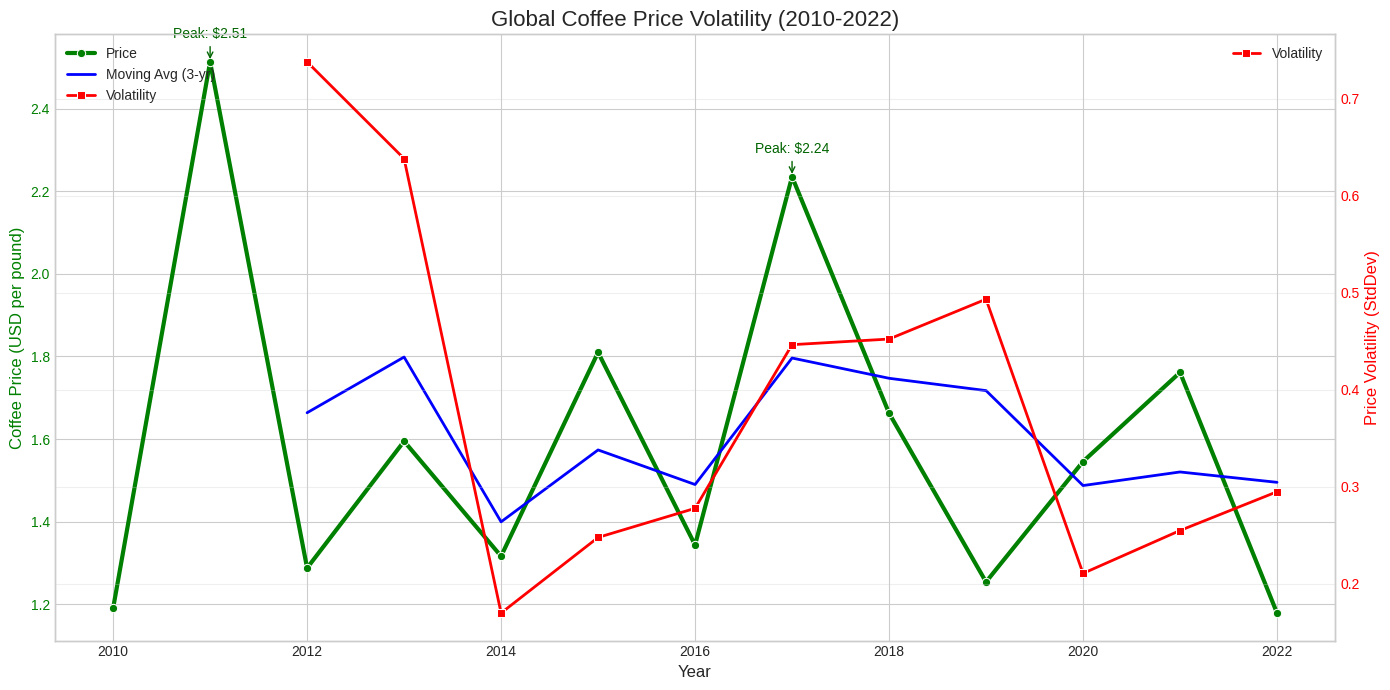

In [10]:
# Cell 7: Price Volatility Analysis - Visualization 3
# Coffee price volatility over time
price_volatility = coffee_data[['Year', 'Price']]
price_volatility['Year_label'] = price_volatility['Year'].dt.year

# Calculate moving average and volatility
price_volatility['MA_12'] = price_volatility['Price'].rolling(window=3).mean() # Using 3 as we have yearly data
price_volatility['Volatility'] = price_volatility['Price'].rolling(window=3).std()

# Create price volatility chart
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot price trend
sns.lineplot(data=price_volatility, x='Year_label', y='Price',
             marker='o', linewidth=3, color='green', ax=ax1, label='Price')
sns.lineplot(data=price_volatility, x='Year_label', y='MA_12',
             linewidth=2, color='blue', ax=ax1, label='Moving Avg (3-yr)')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Coffee Price (USD per pound)', color='green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='green')

# Plot volatility
if price_volatility['Volatility'].notna().any():  # Check if we have valid volatility data
    sns.lineplot(data=price_volatility, x='Year_label', y='Volatility',
                 marker='s', linewidth=2, color='red', ax=ax2, label='Volatility')
    ax2.set_ylabel('Price Volatility (StdDev)', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

# Highlight peak years
peak_years = [2011, 2017]
for year in peak_years:
    year_data = price_volatility[price_volatility['Year_label'] == year]
    if not year_data.empty:
        ax1.annotate(f"Peak: ${year_data['Price'].values[0]:.2f}",
                     (year, year_data['Price'].values[0]),
                     xytext=(0, 15), textcoords='offset points',
                     ha='center', va='bottom', fontsize=10, color='darkgreen',
                     arrowprops=dict(arrowstyle='->', color='darkgreen'))

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title('Global Coffee Price Volatility (2010-2022)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

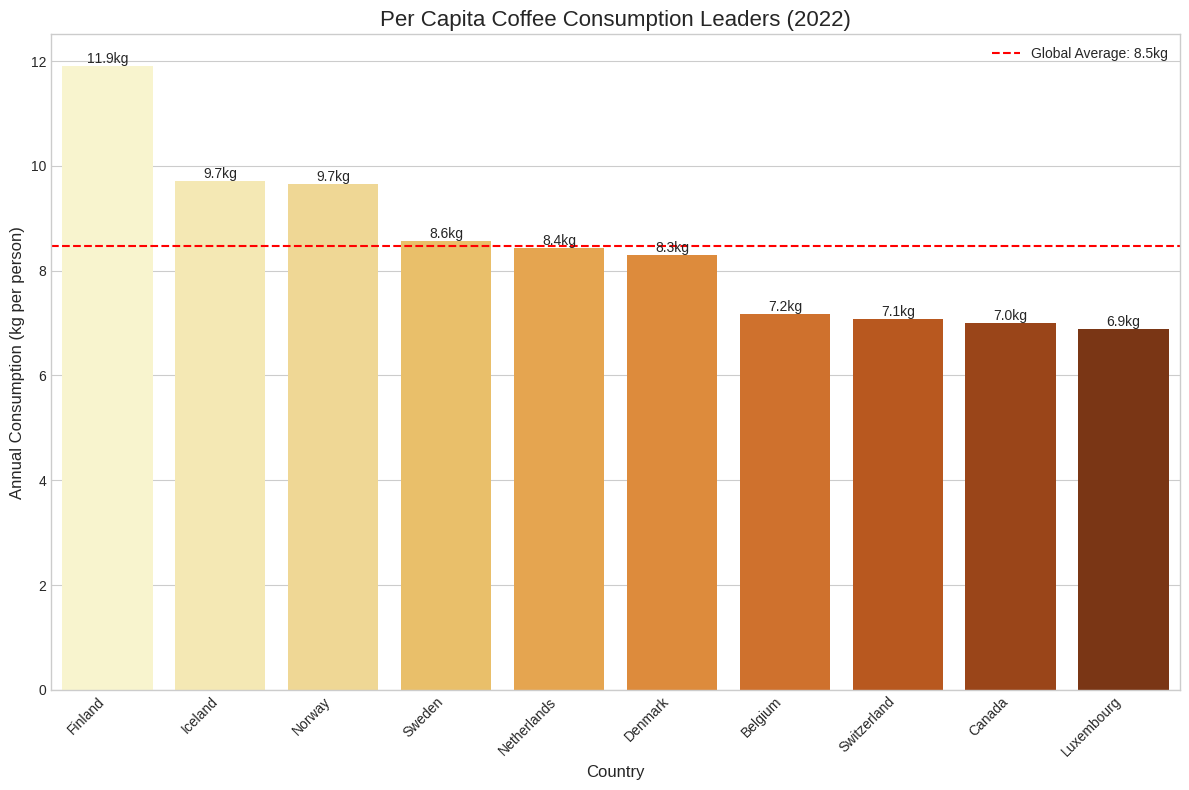

In [11]:
# Cell 8: Per Capita Consumption - Visualization 4
# Per capita consumption leaders
latest_per_capita = per_capita_data[per_capita_data['Year'] == latest_year][per_capita_countries].T.reset_index()
latest_per_capita.columns = ['Country', 'Per_Capita_Consumption']
latest_per_capita = latest_per_capita.sort_values('Per_Capita_Consumption', ascending=False)

# Create per capita consumption bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=latest_per_capita, x='Country', y='Per_Capita_Consumption', palette='YlOrBr')
plt.title('Per Capita Coffee Consumption Leaders (2022)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Annual Consumption (kg per person)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}kg',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom', fontsize=10)

# Add global average line
global_avg = latest_per_capita['Per_Capita_Consumption'].mean()
plt.axhline(y=global_avg, color='red', linestyle='--',
           label=f'Global Average: {global_avg:.1f}kg')
plt.legend()

plt.tight_layout()
plt.show()

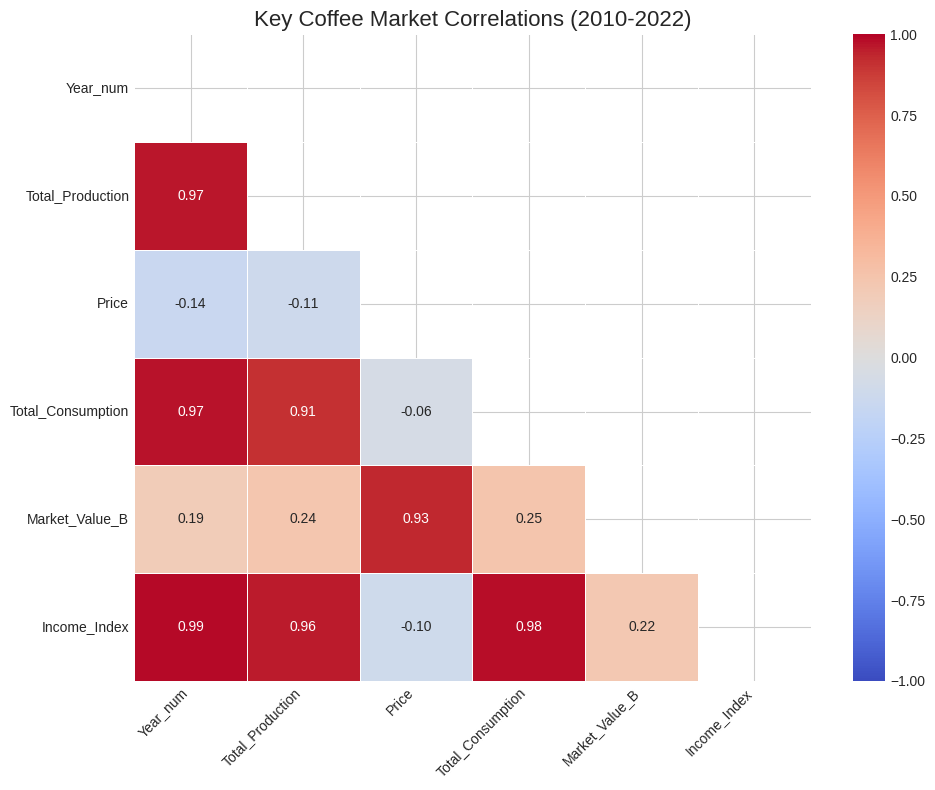

Key Market Correlations:
Price-Production Correlation: -0.11
Consumption-Income Correlation: 0.98
Production-Consumption Correlation: 0.91
Price-Market Value Correlation: 0.93


In [12]:
# Cell 9: Correlation Analysis - Visualization 5
# Create correlation dataset with key metrics
corr_data = coffee_data[['Year_num', 'Total_Production', 'Price', 'Total_Consumption', 'Market_Value_B']].copy()

# Add simulated income data (GDP per capita index)
corr_data['Income_Index'] = np.linspace(100, 130, len(years)) + np.random.normal(0, 2, len(years))

# Create correlation heatmap
corr = corr_data.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Key Coffee Market Correlations (2010-2022)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print key correlations
print("Key Market Correlations:")
print(f"Price-Production Correlation: {corr.loc['Price', 'Total_Production']:.2f}")
print(f"Consumption-Income Correlation: {corr.loc['Total_Consumption', 'Income_Index']:.2f}")
print(f"Production-Consumption Correlation: {corr.loc['Total_Production', 'Total_Consumption']:.2f}")
print(f"Price-Market Value Correlation: {corr.loc['Price', 'Market_Value_B']:.2f}")

                               SARIMAX Results                                
Dep. Variable:         Market_Value_B   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  89.366
Date:                Tue, 15 Apr 2025   AIC                           -172.733
Time:                        19:04:33   BIC                           -172.141
Sample:                    12-31-2010   HQIC                          -174.009
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2915   7.06e-19  -4.13e+17      0.000      -0.291      -0.291
ma.L1         -0.6144   5.48e-19  -1.12e+18      0.000      -0.614      -0.614
sigma2      1.618e-10   6.95e-10      0.233      0.8

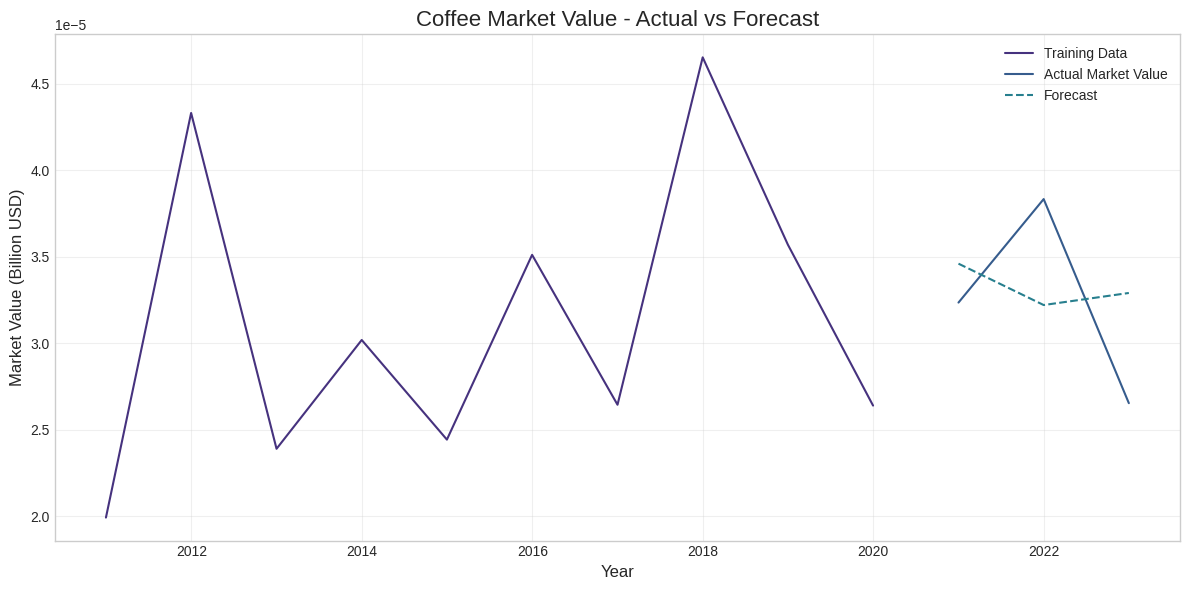

In [13]:
# Cell 10: Time Series Modeling
# Prepare time series data for market value prediction
ts_data = coffee_data[['Year', 'Year_num', 'Market_Value_B']].set_index('Year')

# Split data into train and test
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# ARIMA model for market value
model = ARIMA(train['Market_Value_B'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))
forecast_df = pd.DataFrame({'Forecast': forecast}, index=test.index)

# Calculate error metrics
mse = mean_squared_error(test['Market_Value_B'], forecast)
rmse = np.sqrt(mse)
print(f"ARIMA Model Performance - RMSE: {rmse:.2f}")

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Market_Value_B'], label='Training Data')
plt.plot(test.index, test['Market_Value_B'], label='Actual Market Value')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Coffee Market Value - Actual vs Forecast', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Market Value (Billion USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

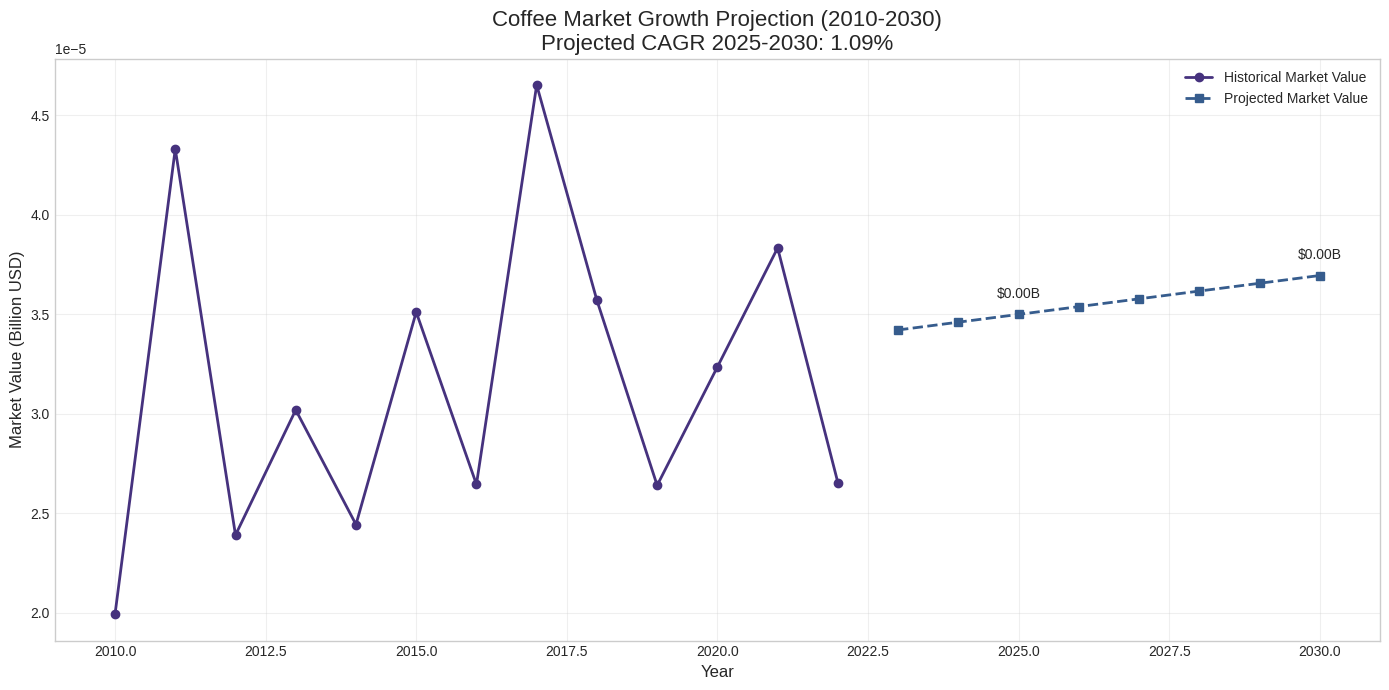

In [14]:
# Cell 11: Future Projection Model
# Create future time periods for projection
future_years = pd.date_range(start='2023-01-01', end='2030-12-31', freq='Y')
future_df = pd.DataFrame({'Year': future_years})
future_df['Year_num'] = future_df['Year'].dt.year

# Build a regression model to project market value
X = coffee_data[['Year_num']]
y = coffee_data['Market_Value_B']

model = LinearRegression()
model.fit(X, y)

# Project market value for future years
future_market_value = model.predict(future_df[['Year_num']])
future_df['Projected_Market_Value'] = future_market_value

# Combine historical and projected data
projection_df = pd.DataFrame({
    'Year': pd.concat([coffee_data['Year'], future_df['Year']]),
    'Year_num': pd.concat([coffee_data['Year_num'], future_df['Year_num']]),
    'Market_Value': pd.concat([coffee_data['Market_Value_B'], pd.Series([None] * len(future_df))]),
    'Projected_Value': pd.concat([pd.Series([None] * len(coffee_data)), future_df['Projected_Market_Value']])
})

# Calculate CAGR for 2025-2030
value_2025 = future_df[future_df['Year_num'] == 2025]['Projected_Market_Value'].values[0]
value_2030 = future_df[future_df['Year_num'] == 2030]['Projected_Market_Value'].values[0]
years = 5  # 2025 to 2030
cagr = ((value_2030 / value_2025) ** (1/years) - 1) * 100

# Plot the projection
plt.figure(figsize=(14, 7))
plt.plot(projection_df['Year_num'], projection_df['Market_Value'], marker='o', linewidth=2, label='Historical Market Value')
plt.plot(projection_df['Year_num'], projection_df['Projected_Value'], marker='s', linestyle='--', linewidth=2, label='Projected Market Value')

# Add data labels for key years
for year in [2025, 2030]:
    year_data = projection_df[projection_df['Year_num'] == year]
    if not year_data.empty and not pd.isna(year_data['Projected_Value'].values[0]):
        plt.annotate(f"${year_data['Projected_Value'].values[0]:.2f}B",
                    (year, year_data['Projected_Value'].values[0]),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)

plt.title(f'Coffee Market Growth Projection (2010-2030)\nProjected CAGR 2025-2030: {cagr:.2f}%', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Market Value (Billion USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Cell 12: Regional Growth Analysis
# Create sample regional consumption data
regions = ['North America', 'Europe', 'Asia Pacific', 'Latin America', 'Middle East & Africa']
regional_growth = pd.DataFrame({'Year': years_df['Year']})

# Simulate different growth rates by region
for region in regions:
    if region == 'Asia Pacific':
        base = 20 + np.random.normal(0, 1, len(years_df))  # Use years_df instead of years
        growth_rate = 0.08  # 8% annual growth
    elif region == 'North America':
        base = 30 + np.random.normal(0, 1, len(years_df))  # Use years_df instead of years
        growth_rate = 0.03  # 3% annual growth
    elif region == 'Europe':
        base = 35 + np.random.normal(0, 1, len(years_df))  # Use years_df instead of years
        growth_rate = 0.02  # 2% annual growth
    elif region == 'Latin America':
        base = 25 + np.random.normal(0, 1, len(years_df))  # Use years_df instead of years
        growth_rate = 0.04  # 4% annual growth
    else:  # Middle East & Africa
        base = 10 + np.random.normal(0, 0.5, len(years_df))  # Use years_df instead of years
        growth_rate = 0.06  # 6% annual growth

    # Apply compound growth
    years_passed = np.arange(len(years_df))  # Use years_df instead of years
    growth_factors = (1 + growth_rate) ** years_passed
    regional_growth[region] = base * growth_factors

regional_growth['Year_num'] = regional_growth['Year'].dt.year

# ... (Rest of the code in Cell 12 remains the same)

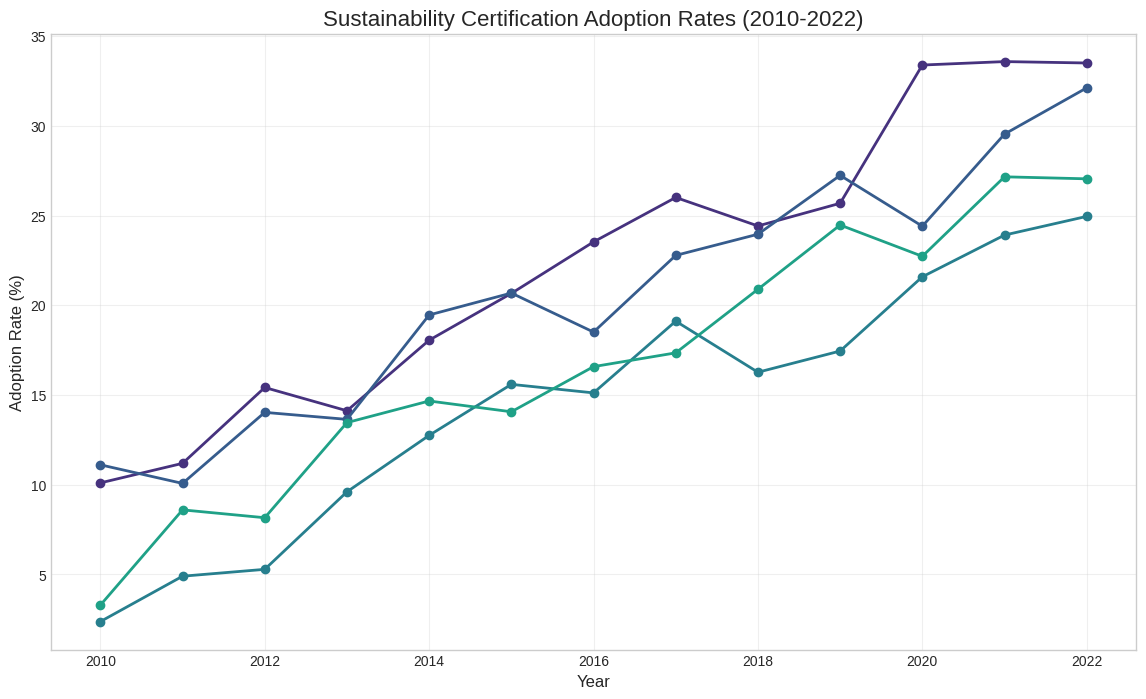

In [17]:
# Cell 13: Sustainability Analysis
plt.figure(figsize=(14, 8))
for cert in ['Fair_Trade', 'Organic', 'Rainforest_Alliance', 'UTZ']:
    plt.plot(sustainability_data['Year'].dt.year, sustainability_data[cert], marker='o', linewidth=2, label=cert)

plt.title('Sustainability Certification Adoption Rates (2010-2022)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Adoption Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)